In [34]:
from google.colab import drive
import os

drive.mount("/content/gdrive")
path = "/content/gdrive/My Drive/Colab Notebooks/Facenet"
os.chdir(path)
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
build			     faces.pkl
data			     face_yale.h5
Dataset			     haarcascade_frontalface_default.xml
dlib			     id_test.pkl
Download.ipynb		     id_train.pkl
embed_blob_faces.pkl	     images_file.pkl
faceNetAlgorithm.ipynb	     nn4.small2.v1.t7
faceNet_Augumentation.ipynb  predictions.png
faceNet_v2.ipynb	     YALE
Facenet_v3.ipynb	     YALE.tar.gz
face-recognition-opencv      y_labels.pkl


# 1. Cài đặt các package cần thiết

Tiếp nối [bài 27 model facenet](https://phamdinhkhanh.github.io/2020/03/12/faceNetAlgorithm.html). Trong bài này mình sẽ hướng dẫn các bạn cách thức xây dựng và huấn luyện model facenet cho bộ dữ liệu của mình. Bài thực hành được viết trên google colab. Các bạn mở trực tiếp [link hướng dẫn facenet](https://colab.research.google.com/drive/1jX3DL1RoQiboEYlYQygmJcEfyVitfsVH) để bắt đầu các bước nhé.

Ngoài ra để tạo thuận lợi cho việc thực hành, mọi git repository của blog được lưu dữ tại [khanhBlogTurtorial](https://github.com/phamdinhkhanh/khanhBlogTurtorial.git)

## 1.1. install face_recognition

Mục đích chính của package face_recognition là để phát hiện vị trí các khuôn mặt trong ảnh.

Có khá nhiều phương pháp để bắt vị trí khuôn mặt trong ảnh. Chúng ta có thể sử dụng:

* [Face Haar Cascade](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html): Đây là phương pháp base trên machine learning classification. Mô hình được huấn luyện trên các bộ dữ liệu lớn gồm nhiều ảnh có hoặc không xuất hiện vật thể. Phương pháp này có tốc độ khá cao, tuy nhiên độ chính xác thì không được tốt như áp dụng deep learning. Bạn cũng có thể sử dụng haar cascade để huấn luyện nhận diện các object của mình như xe cộ, người, động vật, .... Trên opencv đã có sẵn rất nhiều các model pretrain Cascade cho các vật thể này.

* [module face_recognition](https://github.com/ageitgey/face_recognition): Đây là  Một pretrain model được xây dựng từ một mạng CNN trên bộ dữ liệu kích thước lớn. Mô hình này có độ chính xác cao. Có khả năng bắt được vị trí khuôn mặt ở những vị trí cường độ sáng và góc nghiêng mà haar cascade phát hiện kém hơn. Tuy nhiên tốc độ thì có thể chậm hơn so với haar cascade.

Cả 2 phương pháp trên đều cho phép xác định vị nhiều khuôn mặt trên cùng 1 bức ảnh.

![](https://imgur.com/QhwBkHx.png)


**Hình 1:** So sánh giữa 2 phương pháp Face haar cascade (khung mà đỏ) và face_recognition (khung màu xanh) cho thấy face_recognition phát hiện được hầu hết các khuôn mặt trong khi haar cascade bỏ sót nhiều khuôn mặt ở vị trí đầu tiên. 


Để cài package bạn gõ lệnh

In [2]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 104kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=936d23a269185f223973d8010a10dde0efe940c5d30220fe01ec8da2b86a8e80
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


## 1.2. Các packages khác

Ngoài ra bạn cũng cần cài đặt thêm các packages khác như opencv2, tensorflow version 2.x. Đối với các bạn thực hành trên google colab, tất cả đã sẵn có.

# 2. Dataset

Bộ dữ liệu của chúng ta sẽ là một bộ dữ liệu gồm 150 ảnh của 5 người, mỗi người 5 ảnh.

Tôi đã chuẩn bị sẵn một bộ dữ liệu này. Bạn run lệnh bên dưới để clone data.

In [5]:
!git clone https://github.com/phamdinhkhanh/FacenetDataset.git ./Dataset

Cloning into './Dataset2'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 160 (delta 5), reused 155 (delta 0), pack-reused 0
Receiving objects: 100% (160/160), 13.10 MiB | 16.16 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (150/150), done.


Mỗi folder là ảnh của một người. Chúng ta có tổng cộng 5 folder

# 3. Sử dụng Pretrain model

Như [bài 27](https://phamdinhkhanh.github.io/2020/03/12/faceNetAlgorithm.html) chúng ta đã biết, một khuôn mặt cần được nhúng dưới một véc tơ 128 chiều để mã hóa nó. Trong bài này chúng ta sẽ thử nghiệm 2 phương pháp khác nhau và so sánh hiệu quả.

* Phương pháp 1: Sử dụng pretrain model.
* Phương pháp 2: Huấn luyện lại một model mới cho dữ liệu của mình.

## 3.1. Pretrain model

Chúng ta sẽ sử dụng pretrain model có tác dụng embedding các khuôn mặt có trong bức ảnh thành những véc tơ embedding 128 chiều. File pretrain chính là `nn4.small2.v1.t7` trong git project.

Do model được huấn luyện từ pytorch nên sẽ cần các hàm để load model từ lên opencv như bên dưới.






In [0]:
# Hàm load model
## Load model từ Caffe
import cv2
import os
import numpy as np


EMBEDDING_FL = os.path.join(path, "nn4.small2.v1.t7")
DATASET_PATH = os.path.join(path, "Dataset")

def _load_torch(model_path_fl):
  """
  model_path_fl: Link file chứa weigth của model
  """
  model = cv2.dnn.readNetFromTorch(model_path_fl)
  return model

In [0]:
encoder = _load_torch(EMBEDDING_FL)

## 3.2. Convert ảnh bob

Model pretrain sẽ sử dụng input là blob images. Mục đích của blob images là để giảm nhiễu cho ảnh do chiếu sáng (illumination). Đây là bước tiền xử lý dữ liệu cần thiết khi xây dựng các model xử lý ảnh nói chung. 

![Blob Image](https://imgur.com/4y2ANMo.png)

**Hình 1:** Ảnh gốc và ảnh đã được blob. Ta có thể nhận thấy ảnh đã được segment thành các vùng ảnh có chung cường độ màu sắc. Do đó ảnh hưởng của thay đổi màu sắc do ánh sáng đã được giảm thiểu.

Ngoài ra các bạn cũng có thể áp dụng các phương pháp khác như [canny](https://phamdinhkhanh.github.io/2020/01/06/ImagePreprocessing.html#23-ph%C6%B0%C6%A1ng-ph%C3%A1p-canny-ph%C3%A1t-hi%E1%BB%87n-edge) để tiền xử lý dữ liệu và so sánh hiệu quả.

Hàm `_blogImage()` được sử dụng để convert hình ảnh RGB thành ảnh blob.

In [0]:
import cv2

def _blobImage(image, out_size = (300, 300), scaleFactor = 1.0, mean = (104.0, 177.0, 123.0)):
  """
  input:
    image: ma trận RGB của ảnh input
    out_size: kích thước ảnh blob
  return:
    imageBlob: ảnh blob
  """
  # Chuyển sang blobImage để tránh ảnh bị nhiễu sáng
  imageBlob = cv2.dnn.blobFromImage(image, 
                                    scalefactor=scaleFactor,   # Scale image
                                    size=out_size,  # Output shape
                                    mean=mean,  # Trung bình kênh theo RGB
                                    swapRB=False,  # Trường hợp ảnh là BGR thì set bằng True để chuyển qua RGB
                                    crop=False)
  return imageBlob


## 3.3. Trích suất các khuôn mặt.

Hàm `_extract_bbox()` có tác dụng trích xuất các vị trí khuôn mặt.

In [0]:
from face_recognition import face_locations
import matplotlib.pyplot as plt

IMAGE_TEST = os.path.join(path, "Dataset/khanh/001.jpg")

def _image_read(image_path):
  """
  input:
    image_path: link file ảnh
  return:
    image: numpy array của ảnh
  """
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image


image = _image_read(IMAGE_TEST)

def _extract_bbox(image, single = True):
  """
  Trích xuất ra tọa độ của face từ ảnh input
  input:
    image: ảnh input theo kênh RGB. 
    single: Lấy ra 1 face trên 1 bức ảnh nếu True hoặc nhiều faces nếu False. Mặc định True.
  return:
    bbox: Tọa độ của bbox: <start_Y>, <start_X>, <end_Y>, <end_X>
  """
  bboxs = face_locations(image)
  if len(bboxs)==0:
    return None
  if single:
    bbox = bboxs[0]
    return bbox
  else:
    return bboxs

Hàm `_extract_face()` sẽ trích suất ra ra ảnh RGB của face.

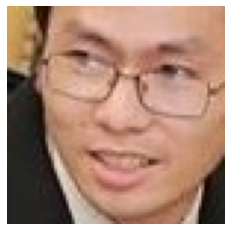

In [13]:
def _extract_face(image, bbox, face_scale_thres = (20, 20)):
  """
  input:
    image: ma trận RGB ảnh đầu vào
    bbox: tọa độ của ảnh input
    face_scale_thres: ngưỡng kích thước (h, w) của face. Nếu nhỏ hơn ngưỡng này thì loại bỏ face
  return:
    face: ma trận RGB ảnh khuôn mặt được trích xuất từ image input.
  """
  h, w = image.shape[:2]
  try:
    (startY, startX, endY, endX) = bbox
  except:
    return None
  minX, maxX = min(startX, endX), max(startX, endX)
  minY, maxY = min(startY, endY), max(startY, endY)
  face = image[minY:maxY, minX:maxX].copy()
  # extract the face ROI and grab the ROI dimensions
  (fH, fW) = face.shape[:2]

  # ensure the face width and height are sufficiently large
  if fW < face_scale_thres[0] or fH < face_scale_thres[1]:
    return None
  else:
    return face

bbox = _extract_bbox(image)
face = _extract_face(image, bbox)
plt.axis("off")
plt.imshow(face)

Tiếp theo ta sẽ tạo vòng lặp trích suất khuông mặt từ các bức ảnh và lưu trữ vào một pickle file. Do giả định mỗi bức ảnh chỉ bao gồm 1 người nên `_extract_bbox()` được thiết lập `single=True`.

In [15]:
from imutils import paths
DATASET_PATH = "./Dataset"

def _model_processing(face_scale_thres = (20, 20)):
  """
  face_scale_thres: Ngưỡng (W, H) để chấp nhận một khuôn mặt.
  """
  image_links = list(paths.list_images(DATASET_PATH))
  images_file = [] 
  y_labels = []
  faces = []
  total = 0
  for image_link in image_links:
    split_img_links = image_link.split("/")
    # Lấy nhãn của ảnh
    name = split_img_links[-2] 
    # Đọc ảnh
    image = _image_read(image_link)
    (h, w) = image.shape[:2]
    # Detect vị trí các khuôn mặt trên ảnh. Gỉa định rằng mỗi bức ảnh chỉ có duy nhất 1 khuôn mặt của chủ nhân classes.
    bbox =_extract_bbox(image, single=True)
    # print(bbox_ratio)
    if bbox is not None:
      # Lấy ra face
      face = _extract_face(image, bbox, face_scale_thres = (20, 20))
      if face is not None:
        faces.append(face)
        y_labels.append(name)
        images_file.append(image_links)
        total += 1
      else:
        next
  print("Total bbox face extracted: {}".format(total))
  return faces, y_labels, images_file

faces, y_labels, images_file = _model_processing()

Total bbox face extracted: 142


Nhớ lưu dữ liệu vào các file pickle để load lên dùng lại khi cần.

In [0]:
import pickle

def _save_pickle(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pickle(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
  return obj

_save_pickle(faces, "./faces.pkl")
_save_pickle(y_labels, "./y_labels.pkl")
_save_pickle(images_file, "./images_file.pkl")

## 3.4. Embedding từ pretrain model

Ở bước 3.1 chúng ta đã load model encoder. Tiếp theo chúng ta sẽ sử dụng các ảnh khuôn mặt đã được trích xuất từ bước 3.2 để tạo embedding véc tơ. Đầu vào của model sẽ là các ảnh blob kích thước `96x96` nên ta sẽ convert dữ liệu về ảnh blob và sau đó truyền qua encoder.

In [0]:
def _embedding_faces(encoder, faces):
  emb_vecs = []
  for face in faces:
    faceBlob = _blobImage(face, out_size = (96, 96), scaleFactor=1/255.0, mean=(0, 0, 0))
    # Embedding face
    encoder.setInput(faceBlob)
    vec = encoder.forward()
    emb_vecs.append(vec)
  return emb_vecs

embed_faces = _embedding_faces(encoder, faces)
# Nhớ save embed_faces vào Dataset.
_save_pickle(embed_faces, "./embed_blob_faces.pkl")

## 3.5. Most similarity

Để thuận tiện cho so sánh hiệu quả giữa model pretrain và model self-training chúng ta sẽ phân chia tập dữ liệu thành tập train và test với tỷ lệ `80:20` và so sánh độ chính xác chỉ trên tập test.



In [0]:
embed_faces = _load_pickle("./embed_blob_faces.pkl")
y_labels = _load_pickle("./y_labels.pkl")

In [26]:
from sklearn.model_selection import train_test_split
ids = np.arange(len(y_labels))

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(np.stack(embed_faces), y_labels, ids, test_size = 0.2, stratify = y_labels)
X_train = np.squeeze(X_train, axis = 1)
X_test = np.squeeze(X_test, axis = 1)
print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))

(113, 128) (29, 128)
113 29


In [0]:
_save_pickle(id_train, "./id_train.pkl")
_save_pickle(id_test, "./id_test.pkl")

Sau khi lấy được dữ liệu các khuôn mặt, chúng ta sẽ sử dụng phương pháp [learning similarity](https://phamdinhkhanh.github.io/2020/03/12/faceNetAlgorithm.html) ở bài 27 để tìm kiếm các ảnh tương đồng nhất làm nhãn cho ảnh dự báo. Theo phương pháp này chúng ta sẽ không bị phụ thuộc vào số lượng classes khi output thay đổi. Để tính toán similarity ta dùng hàm cosine_similarity của sklearn, khá đơn giản.

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

def _most_similarity(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1]
  label = [labels[idx] for idx in argmax][0]
  return label

# Lấy ngẫu nhiên một bức ảnh trong test
vec = X_test[1].reshape(1, -1)
# Tìm kiếm ảnh gần nhất
_most_similarity(X_train, vec, y_train)

'baejun'

Kiểm tra độ chính xác trên tập test

In [0]:
# def _acc_test(test_set, y_test):
from sklearn.metrics import accuracy_score

y_preds = []
for vec in X_test:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train, vec, y_train)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

0.6206896551724138


Như vậy với phương pháp sử dụng lại pretrain model thì chúng ta chỉ đạt độ chính xác là `62%` trên tập test. Kết quả của các bạn cũng sẽ khác mình một chút. Đây là một tỷ lệ khá thấp vậy có cách nào để cải thiện độ chính xác của model không? Chúng ta cùng tìm hiểu ở mục tiếp theo. Huấn luyện model bằng triplot loss function.

# 4. Training triplot loss

Model pretrain đã không phát huy tác dụng. Nguyên nhân chính mình nghĩ rằng pretrain model đã được training trên tập ảnh của người châu âu, trong khi khuôn mặt của người châu âu khá khác biệt so với người châu á. Do đó chúng ta sẽ cần tự huấn luyện lại model facenet cho riêng bộ dữ liệu của mình. Chúng ta kì vọng mô hình sẽ tìm ra biểu diễn cho tập ảnh trên không gian 128 chiều tốt hơn.

Khó khăn nhất của việc tự huấn luyện đó là phải tùy biến lại hàm loss function. Điều này khá khó đối với các beginners. Mình thì muốn `simple is the best` nên sử dụng luôn [TripletSemiHardLoss](https://www.tensorflow.org/addons/tutorials/losses_triplet) của `tensorflow` bản `2.x.x`.

## 4.1. Base network model

`base_netwok` model dự kiến của mình là VGG19. Chúng ta có thể dễ dạng load kiến trúc này nhừ keras

In [19]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

def _base_network():
  model = VGG16(include_top = True, weights = None)
  dense = Dense(128)(model.layers[-4].output)
  norm2 = Lambda(lambda x: tf.math.l2_normalize(x, axis = 1))(dense)
  model = Model(inputs = [model.input], outputs = [norm2])
  return model

model = _base_network()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 4.2. Preprocessing data

Ta thấy dữ liệu ảnh các khuôn mặt hiện tại đang không cùng shape. Do đó cần thực hiện các preprocessing image.

Chúng ta sẽ resize lại các ảnh thông qua hàm resize của opencv.

In [0]:
faces = _load_pickle("./faces.pkl")

In [29]:
import cv2

faceResizes = []
for face in faces:
  face_rz = cv2.resize(face, (224, 224))
  faceResizes.append(face_rz)

X = np.stack(faceResizes)
X.shape

(142, 224, 224, 3)

Phân chia tập train/test

In [35]:
id_train = _load_pickle("./id_train.pkl")
id_test = _load_pickle("./id_test.pkl")

X_train, X_test = X[id_train], X[id_test]

print(X_train.shape)
print(X_test.shape)

(113, 224, 224, 3)
(29, 224, 224, 3)


## 4.3. Triplet-semi-hard loss

Chúng ta sẽ sử dụng hàm triplet semi hard loss của tensorflow cho nhanh. Không phải code lại từ đầu và rất tiết kiệm thời gian. Về cách sử dụng hàm loss function này bạn xem thêm tại [Triplet-semi-hard loss](https://www.tensorflow.org/addons/tutorials/losses_triplet).

Để sử dụng loss function triplet ta cần complile model như sau:

In [0]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

## 4.4. Huấn luyện model

Để huấn luyện model, ta khởi tạo một tensorflow dataset với batch_size = 32 và shuffle sau mỗi 1024 steps.

In [0]:
print(X_train.shape, len(y_train))

gen_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat().shuffle(1024).batch(32)
gen_train

(113, 224, 224, 3) 113


<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.uint8, tf.string)>

In [0]:
history = model.fit(
    gen_train,
    steps_per_epoch = 50,
    epochs=10)

Train for 50 steps
Epoch 1/10
50/50 [==============================] - 21s 421ms/step - loss: 0.9579
Epoch 2/10
50/50 [==============================] - 20s 405ms/step - loss: 0.9127
Epoch 3/10
50/50 [==============================] - 20s 408ms/step - loss: 0.8601
Epoch 4/10
50/50 [==============================] - 21s 412ms/step - loss: 0.7297
Epoch 5/10
50/50 [==============================] - 21s 414ms/step - loss: 0.5813
Epoch 6/10
50/50 [==============================] - 21s 414ms/step - loss: 0.2593
Epoch 7/10
50/50 [==============================] - 20s 407ms/step - loss: 0.0092
Epoch 8/10
50/50 [==============================] - 20s 405ms/step - loss: 1.2906e-04
Epoch 9/10
50/50 [==============================] - 20s 406ms/step - loss: 1.5807e-05
Epoch 10/10
50/50 [==============================] - 20s 406ms/step - loss: 0.0000e+00


In [0]:
model.save("model/model_triplot.h5")

## 4.5. Accuracy on test

Sau khi huấn luyện xong mô hình ta cùng kiểm tra accuracy trên tập test

In [0]:
X_train_vec = model.predict(X_train)
X_test_vec = model.predict(X_test)

In [0]:
y_preds = []
for vec in X_test_vec:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train_vec, vec, y_train)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

0.6551724137931034


Như vậy việc huấn luyện lại model trên chính bộ dữ liệu gốc theo Triplot loss function đã giúp chúng ta cải thiện độ chính xác trên tập test lên 3%. Nhưng tỷ lệ này vẫn còn khá thấp. Để hiểu rõ hơn nguyên nhân lỗi là gì, hãy cùng đi phân tích lỗi.

# 5. Phân tích lỗi

Ta sẽ biểu diễn các ảnh bị dự báo sai và xem chúng có đặc điểm gì?

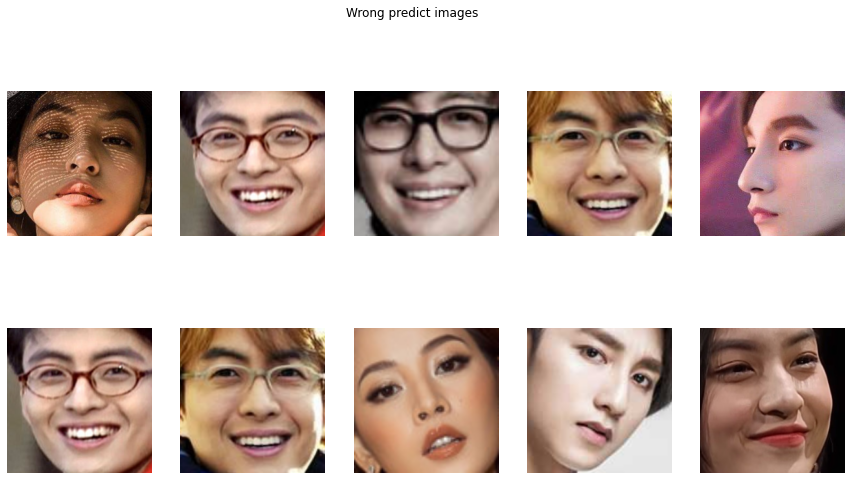

In [0]:
idx_diff = np.flatnonzero(np.array(y_preds) != np.array(y_test))

fg, ax = plt.subplots(2, 5, figsize=(15, 8))
fg.suptitle('Wrong predict images')

for i in np.arange(2):
  for j in np.arange(5):
    ax[i, j].imshow(X_test[idx_diff[i + j + j*i]])
    ax[i, j].set_xlabel('Transform '+str(i+j+j*i))
    ax[i, j].axis('off')

Ta nhận thấy các bức ảnh dự đoán sai đa phần là rơi vào các trạng thái:

* Nhân vật đang cười.

* Chụp ở một góc nghiêng.

* Đội nón.

* Đeo kính

Tiếp theo ta sẽ xem các ảnh này bị dự báo sai với ảnh nào gần nhất.

In [0]:
def _most_similarity_idx(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1][0]
  # label = [labels[idx] for idx in argmax][0]
  return argmax

# Lấy ra các bức ảnh gần nhất với các ảnh dự báo.
nearest_idx = []
for vec in X_test_vec:
  vec = vec.reshape(1, -1)
  argmax = _most_similarity_idx(X_train_vec, vec, y_train)
  nearest_idx.append(argmax)

# Lọc ra tiếp các ảnh bị dự báo sai.
nearest_idx = [nearest_idx[idx] for idx in idx_diff]

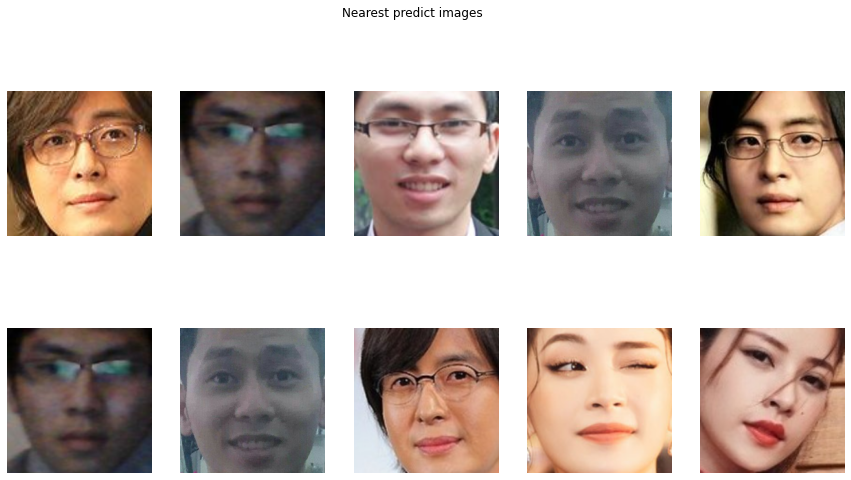

In [0]:
fg, ax = plt.subplots(2, 5, figsize=(15, 8))
fg.suptitle('Nearest predict images')

for i in np.arange(2):
  for j in np.arange(5):
    ax[i, j].imshow(X_train[nearest_idx[i + j + j*i]])
    ax[i, j].set_xlabel('Transform '+str(i+j+j*i))
    ax[i, j].axis('off')

Nhận xét:

* Hầu hết các ảnh cười của bae yong yoon đều bị nhận nhầm thành tôi. Cả 2 đều đeo kính và đang cười.

* Hầu hết các ảnh nhận nhầm có màu da như nhau.

Như vậy để tăng cường hiệu quả nhận dạng thì:

* Các bức ảnh được huấn luyện nên đồng nhất về điều kiện chiếu sáng.  
* Khuôn mặt của nhân vật cần được giữ ở trạng thái thả lỏng, không nhăn nhó.
* Nên thu thập đa dạng các góc nhìn của khuôn mặt. Không chỉ từ góc thẳng đứng mà còn góc nghiêng và các góc độ khác nhau. Chẳng hạn như ảnh quay tròn khuôn mặt như bên dưới.

![](https://camo.githubusercontent.com/134395688734120111c03051bfb62e0d8381ee75/68747470733a2f2f6d656469612e67697068792e636f6d2f6d656469612f336f37614437435a364333524c43764c67732f67697068792e676966)




# 6. Data Augumentation

Chúng ta thử nghiệm một số phương pháp data augumentation để xem kết quả có cải thiện không.

Tiếp theo ta sẽ khởi tạo một ImageDataGenerator để thực hiện một loạt các bến đổi cho hình ảnh. Trong đó bao gồm:

* Chuẩn hóa theo phân phối chuẩn các pixels của ảnh: Trung bình các pixels bằng 0, phương sai bằng 1.

* Tạo các ảnh với các góc nghiêng là 20 độ.

* Dịch chuyển ảnh theo width, height.

* Lật ảnh theo chiều ngang.


Sau khi thực hiện các biến đổi, các biến thể của ảnh sẽ trông như sau:

![](https://imgur.com/U4bCFjh.png)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

Với mỗi bức ảnh trên tập train sẽ lấy ra 5 ảnh biến thể. Như vậy ta có khoảng gần 550 ảnh.

In [0]:
no_batch = 0
X_au = []
y_au = []
for i in np.arange(len(X_train)):
  no_img = 0
  for x in datagen.flow(np.expand_dims(X_train[i], axis = 0), batch_size = 1):
    X_au.append(x[0])
    y_au.append(y_train[i])
    no_img += 1
    if no_img == 5:
      break

## 6.1 Huấn luyện model

In [0]:
import tensorflow_addons as tfa
model2 = _base_network()

model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [0]:
# Điều chỉnh tăng batch_size = 64
gen_train2 = tf.data.Dataset.from_tensor_slices((X_au, y_au)).repeat().shuffle(1024).batch(64)
gen_train2

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>

In [0]:
print(len(X_au), len(y_au))

565 565


In [0]:
history = model2.fit(
    gen_train2,
    steps_per_epoch = 50,
    epochs=20)

Train for 15 steps
Epoch 1/10
15/15 [==============================] - 13s 874ms/step - loss: 0.2821
Epoch 2/10
15/15 [==============================] - 13s 857ms/step - loss: 0.1791
Epoch 3/10
15/15 [==============================] - 13s 870ms/step - loss: 0.1471
Epoch 4/10
15/15 [==============================] - 13s 861ms/step - loss: 0.0672
Epoch 5/10
15/15 [==============================] - 13s 846ms/step - loss: 0.0361
Epoch 6/10
15/15 [==============================] - 13s 834ms/step - loss: 0.0134
Epoch 7/10
15/15 [==============================] - 12s 826ms/step - loss: 0.0018
Epoch 8/10
15/15 [==============================] - 12s 828ms/step - loss: 9.6324e-04
Epoch 9/10
15/15 [==============================] - 12s 825ms/step - loss: 1.8847e-04
Epoch 10/10
15/15 [==============================] - 12s 825ms/step - loss: 1.1150e-04


In [0]:
model2.save("model/model_triplot_au.h5")

## 6.2. Accuracy trên test

Để dự báo trên tập test thì chúng ta sẽ cần phải transform ảnh trên X theo đúng như nguyên tắc tranform trên tập train.

In [0]:
data_tf = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    horizontal_flip=True
    )

data_tf.fit(X_test)

no_batch = 0
X_test_tf = []
for i in np.arange(len(X_test)):
  no_img = 0
  for x in data_tf.flow(np.expand_dims(X_test[i], axis = 0), batch_size = 1):
    X_test_tf.append(x[0])
    no_img += 1
    if no_img == 1:
      break

In [0]:
X_train_vec = model2.predict(np.stack(X_au))
X_test_vec = model2.predict(np.stack(X_test_tf))

In [0]:
y_preds = []
for vec in X_test_vec:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train_vec, vec, y_au)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

0.6896551724137931


Như vậy bạn đã thấy hiệu quả của model rồi chứ? Sau khi thực hiện augumentation thì accuracy của chúng ta đã tăng lên từ 65%-68%. Tôi nghĩ rằng trong điều kiện bộ dữ liệu là không quá tốt thì đây là một kết quả chấp nhận được.

# 7. Dự báo face trên 1 bức ảnh

Trước tiên chúng ta cần tạo một hàm normalize để tiền xử lý ảnh trước khi đưa vào dự báo mô hình.

In [0]:
def _normalize_image(image, epsilon=0.000001):
  means = np.mean(image.reshape(-1, 3), axis=0)
  stds = np.std(image.reshape(-1, 3), axis=0)
  image_norm = image - means
  image_norm = image_norm/(stds + epsilon)
  return image_norm

Sau đó ta thực hiện một vòng lặp để trích suất toàn bộ các faces trên ảnh và dự báo kết quả trên từng face.

In [0]:
IMAGE_OUTPUT = "./predictions.jpg"
IMAGE_PREDICT = "./test1.jpg"

# Trích xuất bbox image 
image = _image_read(IMAGE_PREDICT)
# imageBlob = _blobImage(image)
bboxs = _extract_bbox(image, single=False)
# print(len(bboxs))
faces = []
for bbox in bboxs:
  face = _extract_face(image, bbox, face_scale_thres = (20, 20))
  # face = face.copy()
  faces.append(face)
  try:
    face_rz = cv2.resize(face, (224, 224))
    # Chuẩn hóa ảnh bằng hàm _normalize_image
    face_tf = _normalize_image(face_rz)
    face_tf = np.expand_dims(face_tf, axis = 0)
    # Embedding face
    vec = model2.predict(face_tf)
    # Tìm kiếm ảnh gần nhất
    name = _most_similarity(X_train_vec, vec, y_au)
    # Tìm kiếm các bbox
    (startY, startX, endY, endX) = bbox
    minX, maxX = min(startX, endX), max(startX, endX)
    minY, maxY = min(startY, endY), max(startY, endY)
    pred_proba=0.891
    text = "{}: {:.2f}%".format(name, pred_proba * 100)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.rectangle(image, (minX, minY), (maxX, maxY), (0, 0, 255), 2)
    cv2.putText(image, text, (minX, y),
      cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
  except:
      print("Not found face")
cv2.imwrite(IMAGE_OUTPUT, image)


# import matplotlib.pyplot as plt

plt.figure(figsize = (16, 8))
img = plt.imread(IMAGE_OUTPUT)
plt.imshow(img)

# 8. Kết luận

Như vậy qua bài thực hành này tôi đã hướng dẫn cho các bạn cách thức:

* Sử dụng một pretrain model để embedding véc tơ.
* Tự huấn luyện triplot loss function với bộ dữ liệu của mình.
* Cách thức phân tích lỗi để tìm ra nguyên nhân dự báo thiếu chính xác.
* Kĩ thuật data augumentation để tăng cường accuracy của mô hình.

Ngoài ra khi xây dựng một ứng dụng nhận diện khuôn mặt, mô hình của các bạn có thể dự báo thiếu chính xác. Nguyên nhân xuất phát chủ yếu từ dữ liệu dự báo và dữ liệu huẫn luyện của chúng ta có phân phối quá khác biệt về màu sắc, cường độ các điểm ảnh, hình dạng khuôn mặt. Khi đó một số biện pháp khắc phục đó là:

* Nên đồng nhất điều kiện chụp ảnh cho các bức ảnh huấn luyện. Không lấy các ảnh bị nhiễu sáng, các ảnh có phân phối cường độ sáng khác biệt với phần còn lại. Trong bài này, bộ dữ liệu của chúng ta được thu thập trên mạng nên các ảnh rất khác biệt về cường độ sáng. Tôi đã huấn luyện lại model với bộ dữ liệu YALE thì kết quả đạt được 100% độ chính xác. Bạn đọc có thể thử nghiệm theo hướng dẫn: [facenet training YALE dataset](https://colab.research.google.com/drive/1OTSK9mJdtpuzArCTsEKh5eIq5OmOyq2o).

* Nên lấy ảnh với nhiều góc độ và trạng thái khác nhau.

![](https://camo.githubusercontent.com/134395688734120111c03051bfb62e0d8381ee75/68747470733a2f2f6d656469612e67697068792e636f6d2f6d656469612f336f37614437435a364333524c43764c67732f67697068792e676966)

* Khi triển khai trên ứng dụng. Nên dành 1-2s để tổng hợp nhiều khung hình khuôn mặt từ người được nhận diện. Sau đó tổng hợp kết quả dự đoán từ các khung hình đó để voting một kết quả đa số nhất. Độ chính xác từ việc dự báo nhiều vị trí khuôn mặt sẽ cao hơn so với chỉ lấy từ 1 khuôn mặt.


# 9. Tài liệu tham khảo
1. [Bài 27 - Mô hình Facenet trong face recognition Khanh Blog](https://phamdinhkhanh.github.io/2020/03/12/faceNetAlgorithm.html)
2. [Thực hành Facenet với bộ dữ liệu YALE khanhblog](https://colab.research.google.com/drive/1OTSK9mJdtpuzArCTsEKh5eIq5OmOyq2o)
3. [facenet github davidsandberg](https://github.com/davidsandberg/facenet/issues/591)
4. [face recognition ageitgey](https://github.com/ageitgey/face_recognition)
5. [opencv face recognition - pyimagesearch blog](https://www.pyimagesearch.com/2018/09/24/opencv-face-recognition/)
6. [Face Recognition System Using FaceNet in Keras - machine learning mastery](https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/)